# Clustering over INCOME and AGE across the IRIS

# Import

In [1]:
!pip install openpyxl # for pd.read_excel
!pip install ipywidgets # for tqdm.notebook
!pip install pot


In [2]:
import numpy as np
import ot    # pip install pot
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import geopandas as gpd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sys
sys.path.append("../src")
from clustering_methods import bary_WKMeans, dist_WKMeans
from utils import reconstruct_joint_distribution_ot, computeDistanceMatrix


### Income Deciles per IRIS

In [3]:
# Load the file
df_income_temp = pd.read_csv('../data/BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')


# Decile columns
decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df_income_temp[decile_cols] = df_income_temp[decile_cols].apply(pd.to_numeric, errors='coerce')

# Remove the 1319 rows with missing deciles
df_income = df_income_temp.dropna(subset=decile_cols).reset_index(drop=True)

distributions = df_income[decile_cols].to_numpy()

# Useful 
colors = ['cornflowerblue', 'forestgreen', 'red', 'deeppink', 'orange', 'brown', 'purple']
age_groups = ["0_17", "18_29", "30_39", "40_49", "50_64", "65_74", "75P"]


n_distributions = distributions.shape[0]

### Average Income per age

In [4]:
# Load the file
df_income_age = pd.read_excel("../data/reve-niv-vie-individu-age-med.xlsx", skiprows=3)

# Keep only the 2020 column
df_income_age = df_income_age[["Tranche d’âge", '2020³ ⁴']]

# Rename the column
df_income_age = df_income_age.rename(columns={'2020³ ⁴': "MEDIAN_INCOME"})

# Rename the age groups
renaming_dict = {
    "Moins de 18 ans": "0_17",
    "De 18 à 29 ans": "18_29",
    "De 30 à 39 ans": "30_39",
    "De 40 à 49 ans": "40_49",
    "De 50 à 64 ans": "50_64",
    "De 65 à 74 ans": "65_74",
    "75 ans et plus": "75P"
}
df_income_age["AGE_GROUP"] = df_income_age["Tranche d’âge"].replace(renaming_dict)

# Get rid of the metadata lines
df_income_age = df_income_age[df_income_age['AGE_GROUP'].isin(age_groups)].reset_index(drop=True)

# Keep only the relevant columns
df_income_age = df_income_age[["AGE_GROUP", "MEDIAN_INCOME"]]


In [5]:
df_income.head()

,IRIS,DEC_PIMP20,DEC_TP6020,DEC_Q120,DEC_MED20,DEC_Q320,DEC_EQ20,DEC_D120,DEC_D220,DEC_D320,...,DEC_RD20,DEC_S80S2020,DEC_GI20,DEC_PACT20,DEC_PTSA20,DEC_PCHO20,DEC_PBEN20,DEC_PPEN20,DEC_PAUT20,DEC_NOTE20
0,010040101,"41,8","32,7",10940,18240.0,24950,"0,77",6220.0,9630.0,12440.0,...,"5,3","6,8","0,328","68,0","61,1","4,0","2,9","28,8","3,2",0
1,010040102,"39,0","41,1",9010,15860.0,23660,"0,92",4030.0,7750.0,10150.0,...,"7,8","9,7","0,370","70,4","63,2","4,8","2,4","26,3","3,3",0
2,010040201,"45,6","29,2",11700,19130.0,27000,"0,80",6150.0,10030.0,13260.0,...,"5,7","7,6","0,342","68,9","61,5","3,9","3,5","27,9","3,2",0
3,010040202,"59,8","14,0",17500,24790.0,33710,"0,65",10820.0,15850.0,19050.0,...,"4,1","5,5","0,317","69,9","63,7","2,7","3,5","23,4","6,7",0
4,010330102,"39,1","30,6",11100,19090.0,29590,"0,97",4930.0,9220.0,12910.0,...,"8,6","10,7","0,391","73,2","66,6","5,0","1,6","23,8","3,0",0


### Population per age 

To apply our algorithms using income by age group, we need to estimate the population in each corresponding age range for every IRIS. However, the INSEE population dataset provides age groupings that do not match exactly with those used in the national income-by-age statistics. To reconcile the two, we reconstruct the target age groups — (0–17), (18–29), (30–39), (40–49), (50–64), (65–74), and 75+ — by combining and subtracting available groups from the population dataset. In some cases, we rely on approximations (e.g., estimating the 45–54 group to split 40–49 and 50–64) to ensure consistency with the income data structure. This harmonization step is essential to later compute joint distributions of age and income at the IRIS level.

In [6]:
# Load the Excel sheet
df_pop_temp = pd.read_excel("../data/base-ic-evol-struct-pop-2020.xlsx", sheet_name=0, skiprows=5)

# Directly accessible age groups
df_pop_temp["AGE_0_17"] = df_pop_temp["P20_POP0002"] + df_pop_temp["P20_POP0305"] + df_pop_temp["P20_POP0610"] + df_pop_temp["P20_POP1117"]
df_pop_temp["AGE_18_29"] = df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"] - df_pop_temp["AGE_0_17"]
df_pop_temp["AGE_30_39"] = df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP1824"] - df_pop_temp["AGE_18_29"]
df_pop_temp["AGE_65_74"] = df_pop_temp["P20_POP65P"] - df_pop_temp["P20_POP75P"]
# No processing needed for 75+ age group

# Approximation of the 45–54 group to help deduce 40–49 and 50–64
df_pop_temp["AGE_45_54"] = (
    df_pop_temp["AGE_0_17"] + df_pop_temp["P20_POP1824"] + df_pop_temp["P20_POP2539"] + df_pop_temp["P20_POP4054"]
    - (df_pop_temp["P20_POP0014"] + df_pop_temp["P20_POP1529"] + df_pop_temp["P20_POP3044"])
)

# Approximate 40–49 from 40–54 and part of 45–54
df_pop_temp["AGE_40_49"] = df_pop_temp["P20_POP4054"] - 0.5 * df_pop_temp["AGE_45_54"]

# Approximate 50–64 from 55–64 and part of 45–54
df_pop_temp["AGE_50_64"] = df_pop_temp["P20_POP5564"] + 0.5 * df_pop_temp["AGE_45_54"]

# Renaming for clarity
df_pop_temp["0_17"] = df_pop_temp["AGE_0_17"]
df_pop_temp["18_29"] = df_pop_temp["AGE_18_29"]
df_pop_temp["30_39"] = df_pop_temp["AGE_30_39"]
df_pop_temp["40_49"] = df_pop_temp["AGE_40_49"]
df_pop_temp["50_64"] = df_pop_temp["AGE_50_64"]
df_pop_temp["65_74"] = df_pop_temp["AGE_65_74"]
df_pop_temp["75P"] = df_pop_temp["P20_POP75P"]

# Final columns to keep
final_cols = ["IRIS", "REG", "DEP", "LIBCOM", "LIBIRIS"] + age_groups

df_pop = df_pop_temp[final_cols]


## Joint Age-Income Distributions

### Reconstructing the joint age–income distribution

For each IRIS, we reconstruct a joint probability distribution π over age groups and income levels. The marginal distributions are:
* the age distribution of the IRIS (based on population counts per age group), and
* a uniform distribution over the income deciles observed in the IRIS.

We use optimal transport to find the coupling π that best aligns the income levels with the national average income for each age group, minimizing the cost:

$$
C_{i,j} = |R_j - m(T_i)|
$$

where $R_j$ is the j-th income level (decile), and $m(T_i)$ is the national average income for age group $T_i$.

The result is a joint distribution π (a matrix), interpreted as the most plausible alignment between age and income in the IRIS, under minimal deviation from national trends.

### Computation for Each IRIS

In [7]:
# Compute national median income per age group
age_income_medians = df_income_age.set_index("AGE_GROUP").loc[age_groups, "MEDIAN_INCOME"].to_numpy()

# Find common IRIS identifiers present in both datasets
common_iris = sorted(set(df_income["IRIS"]).intersection(df_pop["IRIS"]))

# Compute joint distributions
joint_distributions = []
joint_supports = []
iris_ids = []

for iris in tqdm(common_iris):
    row_income = df_income[df_income["IRIS"] == iris]
    row_pop = df_pop[df_pop["IRIS"] == iris]

    if row_income.empty or row_pop.empty:
        continue  # Skip if data is missing for this IRIS

    # Age group weights (normalized)
    age_counts = row_pop.iloc[0][age_groups].to_numpy()
    age_weights = age_counts / age_counts.sum()

    # Income decile values
    income_deciles = row_income.iloc[0][decile_cols].to_numpy()

    # Compute the joint distribution π using optimal transport
    pi, supp= reconstruct_joint_distribution_ot(age_weights, income_deciles, age_income_medians)

    joint_supports.append(supp)
    joint_distributions.append(pi)
    iris_ids.append(iris)

# Normalisation des supports pour équilibrer les échelles âge/revenu
def normalize_supports(supports):
    all_supports = np.vstack(supports)
    min_vals = all_supports.min(axis=0)
    max_vals = all_supports.max(axis=0)
    normalized = [(s - min_vals) / (max_vals - min_vals) for s in supports]
    return normalized, min_vals, max_vals

joint_supports, support_min, support_max = normalize_supports(joint_supports)


# Stack the joint distributions into a 3D array: (n_iris, n_age_groups, n_income_deciles)
joint_supports = np.stack(joint_supports)
joint_distributions = np.stack(joint_distributions)


  0%|          | 0/14703 [00:00<?, ?it/s]

In [8]:
print(support_max)

[6.0000e+00 3.5211e+05]


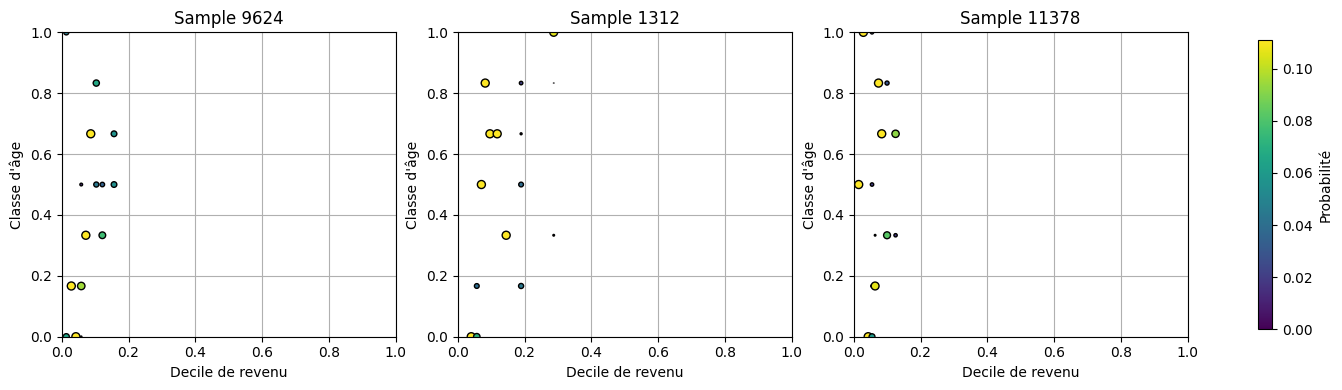

In [9]:
# Exemple avec 3 lois tirées aléatoirement
rng = np.random.default_rng(42)
indices = rng.choice(len(joint_distributions), size=3, replace=False)

plt.figure(figsize=(15, 4))

for i in range(3):
    dist = joint_distributions[indices[i]]
    supp = joint_supports[indices[i]]
    age_classes = supp[:, 0]
    income_deciles = supp[:, 1]

    plt.subplot(1, 3, i + 1)
    scatter = plt.scatter(
        income_deciles, age_classes,
        c=dist,
        cmap='viridis',
        s=300 * dist,  # taille relative au poids
        edgecolor='k'
    )
    plt.title(f"Sample {indices[i]}")
    plt.xlabel("Decile de revenu")
    plt.ylabel("Classe d'âge")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)

plt.tight_layout()
cbar = plt.colorbar(scatter, ax=plt.gcf().axes, shrink=0.95)
cbar.set_label("Probabilité")
plt.show()


# Clustering

## Introduction to Wasserstein K-means

### Distance in the Wasserstein space

We will now try to cluster our IRIS based on the joint-distributions we computed earlier.
To apply a K-means algorithm to this data, we must first define a meaningful distance between observations.

We choose the Earth Mover's Distance (EMD), which corresponds to the Wasserstein distance of order 1. It arises from the Kantorovich optimal transport problem:

$$
\min_{\pi\in\mathbb R_+^{n\times m}}
\sum_{i=1}^n\sum_{j=1}^m \pi_{ij}\,M_{ij}
\quad\text{such that}\quad 
\sum_j \pi_{ij} = a_i,\quad
\sum_i \pi_{ij} = b_j.
$$

Here:

* The constraint $\sum_j \pi_{ij}=a_i$ ensures that the **first marginal** of $\pi$ is $a$.
* The constraint $\sum_i \pi_{ij}=b_j$ ensures that the **second marginal** of $\pi$ is $b$.
* The result of the optimization, called the **cost**, represents the **minimal total cost** of transporting mass from $a$ to $b$ under cost matrix $M$.

This distance is easily computable using the [POT library](https://pythonot.github.io/) (Python Optimal Transport), via the function:

```python
cost = ot.emd2(a, b, M)
```

Where:

* **`a`** is a probability vector of size $n$: $a_i \geq 0$, $\sum_i a_i = 1$. It represents the **first distribution**, supported on $n$ points.
* **`b`** is a probability vector of size $m$: $b_j \geq 0$, $\sum_j b_j = 1$. It represents the **second distribution**, supported on $m$ points.
* **`M`** is a cost matrix of shape $n \times m$, where each element $M_{ij}$ represents the **cost of transporting one unit of mass** from location $i$ to location $j$.

### Quick addition for the cost matrix

All of our joint_distributions share a common discrete structure (7 age groups × 9 income deciles), because we index revenue not by its actual value but by its ordinal decile position. Concretely, each “bin” corresponds to a pair $(\text{age\_idx}, \text{decile\_idx})$, forming a fixed grid.

Because this grid is identical for every IRIS, we can use a single cost matrix for all comparisons:

```python
coords = [(i, j) for i in range(7) for j in range(9)]
cost_matrix = ot.dist(coords, coords)
```

This matrix defines the ground cost as the Euclidean distance between bins in the integer index space. This shared metric lets us compute meaningful Wasserstein distances across different IRIS efficiently, without needing to recompute it for each pair. As noted in optimal transport theory, the cost matrix is independent of the actual distributions because it only depends on how we define the “bins” themselves.

## Clustering based on barycenters (B-WKM)

This **centroid-based Wasserstein K-means** extends the classical Lloyd’s K-means to the space of probability measures by replacing Euclidean centroids and norms with **Wasserstein barycenters** and $W_2^2$ distances. As outlined by Domazakis et al. (2019) and formalized by Zhuang et al. (2022), the algorithm iteratively alternates between assignment and update (see below).

In [ ]:
data = joint_distributions[:1000]
supports = joint_supports[:1000]
n_clusters = 2
random_state = 42
reg=1e-1

rng = np.random.default_rng(random_state)
n_samples = data.shape[0]
shape = data.shape[1:]
n_bins = np.prod(shape)

* **Assignment step**: at each iteration, assign each distribution $\mu_i$ to the cluster whose centroid (a Wasserstein barycenter $\nu_k$) minimizes $W_2(\mu_i, \nu_k)$.

In [ ]:
# Flatten and Normalize the input distributions
data_flat = data.reshape(n_samples, n_bins)
data_flat /= data_flat.sum(axis=1, keepdims=True)

# Initialization: randomly choose initial barycenters among the data
indices = rng.choice(n_samples, size=n_clusters, replace=False)
bary_flat = data_flat[indices]
bary_supports = supports[indices]

assignments = np.zeros(n_samples, dtype=int)

for i in tqdm(range(n_samples), desc="Assigning to barycenters"):
    distances = np.zeros(n_clusters, dtype=float)
    for j in range(n_clusters):
        # Compute cost matrix
        cost_matrix = ot.dist(supports[i], supports[j])
        distances[j] = ot.emd2(data_flat[i], bary_flat[j], cost_matrix)
    assignments[i] = np.argmin(distances)

* **Centroid update step**: recompute each cluster’s centroid as the Wasserstein barycenter of all $\mu_i$ in that cluster—i.e., solve 

$$
\nu_k = \arg \min_{\nu} \frac 1 {|G_k|} \sum_{i \in G_k} W_2^2(\mu_i,\nu)
$$


In [ ]:
bary_flat = []
bary_supports = []

for k in tqdm(range(n_clusters), desc="Recomputing barycenters"):
    # Indices des distributions du cluster k
    cluster_indices = np.where(assignments == k)[0]

    # If the cluster is empty, reinitialize with a random sample
    if len(cluster_indices) == 0:
        idx = rng.integers(0, data.shape[0])
        bary_flat.append(data_flat[idx])
        bary_supports.append(supports[idx])
        continue

    # Récupérer les histogrammes et les supports associés
    cluster_hists = [data_flat[i] for i in cluster_indices]
    cluster_supports = [supports[i] for i in cluster_indices]

    # Construire le support commun (union des supports)
    combined_support = np.unique(np.vstack(cluster_supports), axis=0)

    # Reprojeter chaque histogramme sur le support commun
    projected_hists = []
    for hist, supp in zip(cluster_hists, cluster_supports):
        proj = np.zeros(len(combined_support))
        for i, atom in enumerate(supp):
            # Trouver l’indice correspondant dans le support commun
            idx = np.where((combined_support == atom).all(axis=1))[0][0]
            proj[idx] = hist[i]
        projected_hists.append(proj)

    projected_hists = np.array(projected_hists).T  # (n_bins, n_distributions)

    # Recalculer la cost matrix sur le support commun
    cost_matrix = ot.dist(combined_support, combined_support)

    # Calcul du barycentre régularisé
    bary = ot.bregman.barycenter(projected_hists, cost_matrix, reg)

    # Stocker le barycentre et son support
    bary_flat.append(bary)
    bary_supports.append(combined_support)

# Reshape barycenters
bary_hists = [b.reshape(shape) for b in bary_flat]



While intuitive, this method can suffer from irregularity and instability in barycenters due to the non‑Euclidean curvature of Wasserstein space, which may lead to poor cluster representation and convergence issues.

In [ ]:
def wbarycenter_clustering_v0(data, n_clusters=3, n_iter=10, reg=1e-1, random_state=None):
    """
    Wasserstein K-Means barycenter-based clustering by Yubo Zhuang et al. (2022)
    for n-dimensional histograms.

    Parameters:
        data: np.ndarray of shape (n_samples, shape)
            Input histograms
        n_clusters: int
            Number of clusters.
        n_iter: int
            Number of iterations.
        reg: float
            Entropic regularization strength.
        random_state: int or None
            Random seed for reproducibility.

    Returns:
        assignments: np.ndarray of shape (n_samples,)
            Cluster assignments.
        barycenters: list of np.ndarray
            Cluster barycenters.
    """    
    rng = np.random.default_rng(random_state)
    n_samples = data.shape[0]
    shape = data.shape[1:]
    n_bins = np.prod(shape)

    # Initialization: randomly choose initial barycenters among the data
    barycenters = data[rng.choice(n_samples, size=n_clusters, replace=False)]

    # Flatten the input distributions
    data_flat = data.reshape(n_samples, n_bins) 
    # Optional: uncomment below (if needed) to avoid numerical issues with NaN or empty barycenters
    # data_flat = np.where(data_flat < 1e-12, 1e-12, data_flat)

    # Normalize distributions to ensure they are valid probabilities
    data_flat /= data_flat.sum(axis=1, keepdims=True)

    # Compute cost matrix
    coords = np.array([(i, j) for i in range(shape[0]) for j in range(shape[1])])
    cost_matrix = ot.dist(coords, coords)

    for it in tqdm(range(n_iter), desc="Wasserstein clustering iterations"):

        # Flatten and normalize barycenters
        bary_flat = np.stack([b.reshape(n_bins) for b in barycenters], axis=0)
        bary_flat /= bary_flat.sum(axis=1, keepdims=True)

        # Step 1: Assignment - assign each distribution to the closest barycenter
        assignments = np.zeros(n_samples, dtype=int)
        
        for i in tqdm(range(n_samples), desc="Assigning to barycenters"):
            distances = np.zeros(n_clusters, dtype=float)
            for j in range(n_clusters):
                distances[j] = ot.emd2(data_flat[i], bary_flat[j], cost_matrix)
            assignments[i] = np.argmin(distances)
    
        # Step 2: Update - recompute the barycenters
        barycenters = []
        for k in tqdm(range(n_clusters), desc="Recomputing barycenters"):
            # Select all members of cluster k
            members = data[assignments == k]

            # If the cluster is empty, reinitialize with a random sample
            if len(members) == 0:
                idx = rng.integers(0, data.shape[0])
                barycenters.append(data[idx])
                continue 

            # Flatten and transpose to get shape (n_bins, n_members)
            A = members.reshape(len(members), n_bins).T

            # Compute regularized Wasserstein barycenter
            bary_flat = ot.bregman.barycenter(A, cost_matrix, reg)

            # Reshape back to original 2D shape
            barycenters.append(bary_flat.reshape(shape))

    return assignments, barycenters

In [ ]:
assignments, barycenters = bary_WKMeans(
    data=joint_distributions,  # (n_iris, 7, 9)
    n_clusters=3,
    n_iter=5,
    reg=0.1,
    random_state=42
)

In [ ]:
# 2 clusters, 1 iter = 20min
# 3 clusters, 2 iter = 26min

# pour toutes les observations (3 clusters, 5it)
# 475min (8h)

# pour 1000 observations (3 clusters, 5it)
# avec clustering_methods : 37.7
# dans le notebook : 36.6

## Clustering based on pairwise distances (D-WKM)

In [10]:
pairwise1 = computeDistanceMatrix(joint_distributions, joint_supports, save=True, filepath='../data/Dis_mat_15k.tkt')

Pairwise distance matrix saved to: ../data/Dis_mat_15k.tkt


In [11]:
pairwise2 = np.loadtxt("../data/Dis_mat_15k.tkt", dtype=float)

In [12]:
np.allclose(pairwise1, pairwise2)


True

In [75]:
assignments = dist_WKMeans(data=joint_distributions, supports=joint_supports, dist_matrix=pairwise1, n_clusters=3, n_iter=20)

Wasserstein pairwise clustering iterations:   0%|          | 0/20 [00:00<?, ?it/s]

In [76]:
np.unique(assignments)

array([0, 1, 2])

In [ ]:
# pour 1000 observations (3 clusters, 5it)
# clustering_methods : 2m35.2

In [ ]:
for i, b in enumerate(barycenters):
    print(f"--- Barycentre {i} ---")
    print(f"Shape: {b.shape}")
    print(f"Min: {b.min():.2e}")
    print(f"Max: {b.max():.2e}")
    print(f"Sum: {b.sum():.6f}")
    print(f"Contains NaN: {np.isnan(b).any()}")
    print(f"Zero elements: {np.sum(b == 0)} / {b.size}")
    print()


In [ ]:
for i, barycenter in enumerate(barycenters):
    plt.figure(figsize=(6, 5))
    plt.imshow(barycenter, cmap='viridis', aspect='auto')
    plt.colorbar(label="Probability")
    plt.title(f"Barycentre {i+1}")
    plt.xlabel("Décile")
    plt.ylabel("Classe d'âge")
    plt.tight_layout()
    plt.show()


In [ ]:
k_values = range(1, 11)

inertias = []
for k_test in tqdm(k_values):
    assignments, barycenters = wbarycenter_clustering(
    data=joint_distributions,  # (n_iris, 7, 9)
    n_clusters=k_test,
    n_iter=5,
    reg=0.1,
    random_state=42
)
    inertia = 0
    for i in range(n_distributions):
        bary = barycenters[assignments[i]]
        inertia += ot.wasserstein_1d(support, support, distributions[i], bary)
    inertias.append(inertia)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters k")
plt.ylabel("Total within-cluster Wasserstein distance")
plt.grid(True)
plt.show()

In [ ]:
k_values = range(1, 11)

inertias = []
for k_test in tqdm(k_values):
    assigments = dist_WKMeans(data=joint_distributions, supports=joint_supports, dist_matrix=pairwise2, n_clusters=k_test, n_iter=20, random_state=42)
    
    
    for k in tqdm(range(k_test), desc="Recomputing barycenters"):
        # Indices des distributions du cluster k
        cluster_indices = np.where(assignments == k)[0]

        # Récupérer les histogrammes et les supports associés
        cluster_hists = [joint_distributions[i] for i in cluster_indices]
        cluster_supports = [joint_supports[i] for i in cluster_indices]

        # Construire le support commun (union des supports)
        combined_support = np.unique(np.vstack(cluster_supports), axis=0)

        # Reprojeter chaque histogramme sur le support commun
        projected_hists = []
        for hist, supp in zip(cluster_hists, cluster_supports):
            proj = np.zeros(len(combined_support))
            for i, atom in enumerate(supp):
                # Trouver l’indice correspondant dans le support commun
                idx = np.where((combined_support == atom).all(axis=1))[0][0]
                proj[idx] = hist[i]
            projected_hists.append(proj)

        projected_hists = np.array(projected_hists).T  # (n_bins, n_distributions)

        # Recalculer la cost matrix sur le support commun
        cost_matrix = ot.dist(combined_support, combined_support)

        # Calcul du barycentre régularisé
        bary = ot.bregman.barycenter(projected_hists, cost_matrix, reg)

        # Stocker le barycentre et son support
        bary_flat.append(bary)
        bary_supports.append(combined_support)

    # Reshape barycenters
    bary_hists = [b.reshape(shape) for b in bary_flat]
        
    inertia = 0
    for i in range(n_distributions):
        bary_id = assignments[i]
        inertia += ot.wasserstein(joint_supports[i], bary_supports[bary_id], joint_distributions[i], bary_flat[bary_id])
    inertias.append(inertia)


# Mapping

## France

In [77]:
gdf_france_raw = gpd.read_file("../data/iris_france.gpkg")

gdf_france = gdf_france_raw[gdf_france_raw["code_iris"].isin(common_iris)].copy()
gdf_france["code_iris"] = gdf_france["code_iris"].astype(str)


iris_cluster_df = pd.DataFrame({
    "code_iris": common_iris,
    "cluster": assignments
})

gdf_france = gdf_france.merge(iris_cluster_df, on="code_iris", how="left")

gdf_france['cluster'] = gdf_france['cluster'].astype('category')



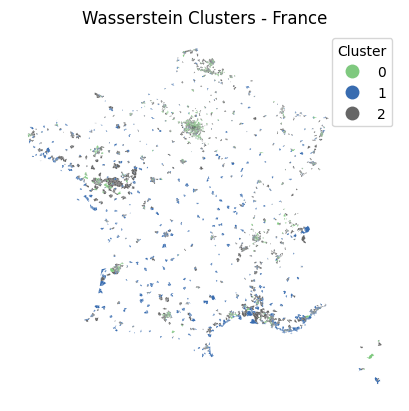

In [78]:
gdf_france.plot(
    column='cluster',
    cmap='Accent',
    legend=True,
    legend_kwds={'title': 'Cluster'},  # Ajoute un titre clair à la légende
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
plt.title("Wasserstein Clusters - France")
plt.axis('off')
plt.show()


## Paris

In [79]:
iris_paris = [iris for iris in common_iris if iris.startswith("75")]
assignments_paris = [assignments[common_iris.index(iris)] for iris in iris_paris]

gdf_idf = gdf_france_raw[gdf_france_raw["code_iris"].isin(iris_paris)].copy()

iris_cluster_df = pd.DataFrame({
    "code_iris": iris_paris,
    "cluster": assignments_paris
})

gdf_idf = gdf_idf.merge(iris_cluster_df, on="code_iris", how="left")

gdf_idf['cluster'] = gdf_idf['cluster'].astype('category')


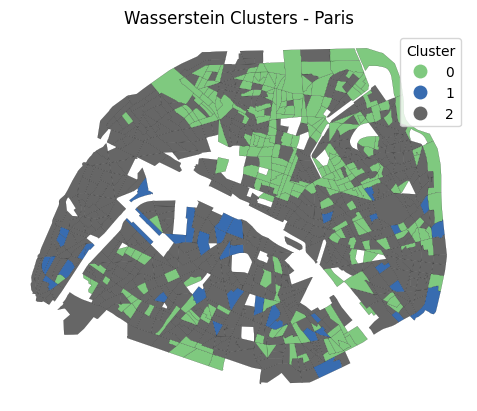

In [80]:
gdf_idf.plot(
    column='cluster',
    cmap='Accent',
    legend=True,
    legend_kwds={'title': 'Cluster'},  # Ajoute un titre clair à la légende
    edgecolor='black',
    linewidth=0.1,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
plt.title("Wasserstein Clusters - Paris")
plt.axis('off')
plt.show()
